# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [2]:
import re
import warnings
import pandas as pd
import numpy as np
import pickle
import os
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

warnings.filterwarnings("ignore")

def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

data = pd.read_csv('preprocessed_data.csv', nrows=50000)

data['project_grade_category'] = data['project_grade_category'].str.replace(' ','_')
data['project_grade_category'] = data['project_grade_category'].str.replace('-','_')
data['project_grade_category'] = data['project_grade_category'].str.lower()

data['clean_categories'] = data['clean_categories'].str.replace(' The ','')
data['clean_categories'] = data['clean_categories'].str.replace(' ','')
data['clean_categories'] = data['clean_categories'].str.replace('&','_')
data['clean_categories'] = data['clean_categories'].str.replace(',','_')
data['clean_categories'] = data['clean_categories'].str.lower()

data['clean_subcategories'] = data['clean_subcategories'].str.replace(' The ','')
data['clean_subcategories'] = data['clean_subcategories'].str.replace(' ','')
data['clean_subcategories'] = data['clean_subcategories'].str.replace('&','_')
data['clean_subcategories'] = data['clean_subcategories'].str.replace(',','_')
data['clean_subcategories'] = data['clean_subcategories'].str.lower()

data['teacher_prefix'] = data['teacher_prefix'].str.replace('.','')
data['teacher_prefix'] = data['teacher_prefix'].str.lower()

data['school_state'] = data['school_state'].str.lower()

stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

preprocessed_essay = preprocess_text(data['essay'].values)

y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)


100%|██████████████████████████████████████████████████████████████████████████| 50000/50000 [00:31<00:00, 1577.69it/s]


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y)

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [4]:
bow_vect1 = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000, binary=True)
bow_vect1.fit(X_train['essay'].values)
X_train_essay_bow = bow_vect1.transform(X_train['essay'].values)
X_test_essay_bow = bow_vect1.transform(X_test['essay'].values)

bow_vect2 = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000, binary=False)
bow_vect2.fit(X_train['teacher_prefix'].values)
X_train_teacher_prefix = bow_vect2.transform(X_train['teacher_prefix'].values)
X_test_teacher_prefix = bow_vect2.transform(X_test['teacher_prefix'].values)

bow_vect2.fit(X_train['project_grade_category'].values)
X_train_pgc = bow_vect2.transform(X_train['project_grade_category'].values)
X_test_pgc = bow_vect2.transform(X_test['project_grade_category'].values)

bow_vect2.fit(X_train['school_state'].values)
X_train_school_state = bow_vect2.transform(X_train['school_state'].values)
X_test_school_state = bow_vect2.transform(X_test['school_state'].values)

bow_vect2.fit(X_train['clean_categories'].values)
X_train_clean_categories = bow_vect2.transform(X_train['clean_categories'].values)
X_test_clean_categories = bow_vect2.transform(X_test['clean_categories'].values)

bow_vect2.fit(X_train['clean_subcategories'].values)
X_train_clean_subcategories = bow_vect2.transform(X_train['clean_subcategories'].values)
X_test_clean_subcategories = bow_vect2.transform(X_test['clean_subcategories'].values)

tfidf_vect = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000, binary=True)
tfidf_vect.fit(X_train['essay'].values)
X_train_essay_tfidf = tfidf_vect.transform(X_train['essay'].values)
X_test_essay_tfidf = tfidf_vect.transform(X_test['essay'].values)




<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [5]:
normalizer = Normalizer()
normalizer.fit(X_train['price'].values.reshape(-1,1))
X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(-1,1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(-1,1))

normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_train_numpreproj_norm = normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
X_test_numpreproj_norm = normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

In [6]:
from scipy.sparse import hstack
X_tr_bow = hstack((X_train_essay_bow, X_train_teacher_prefix, X_train_pgc, X_train_school_state, X_train_clean_categories, X_train_clean_subcategories, X_train_price_norm, X_train_numpreproj_norm)).tocsr()
X_tr_tfidf = hstack((X_train_essay_tfidf, X_train_teacher_prefix, X_train_pgc, X_train_school_state, X_train_clean_categories, X_train_clean_subcategories, X_train_price_norm, X_train_numpreproj_norm)).tocsr()

X_tst_bow = hstack((X_test_essay_bow, X_test_teacher_prefix, X_test_pgc, X_test_school_state, X_test_clean_categories, X_test_clean_subcategories, X_test_price_norm, X_test_numpreproj_norm)).tocsr()
X_tst_tfidf = hstack((X_test_essay_tfidf, X_test_teacher_prefix, X_test_pgc, X_test_school_state, X_test_clean_categories, X_test_clean_subcategories, X_test_price_norm, X_test_numpreproj_norm)).tocsr()


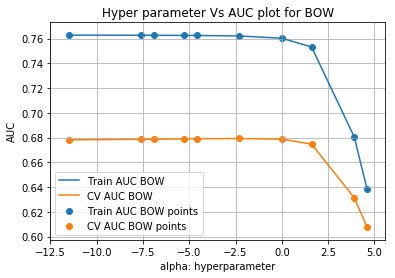

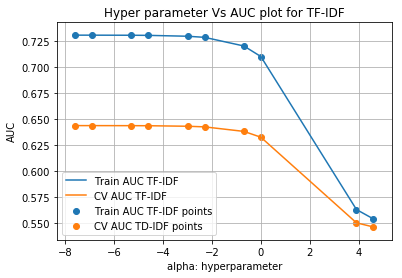

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
multi_NB = MultinomialNB(class_prior=[0.5, 0.5]) 
clf_bow = RandomizedSearchCV(multi_NB, parameters, cv=3, scoring='roc_auc')
clf_bow.fit(X_tr_bow, y_train)

results_bow = pd.DataFrame.from_dict(clf_bow.cv_results_)
results_bow = results_bow.sort_values(['param_alpha'])

train_auc_bow= results_bow['mean_train_score']
train_auc_std_bow= results_bow['std_train_score']
cv_auc_bow = results_bow['mean_test_score'] 
cv_auc_std_bow= results_bow['std_test_score']
alpha_bow =  np.array(results_bow['param_alpha'])
alpha_bow =  np.log(alpha_bow.astype(float))

plt.plot(alpha_bow, train_auc_bow, label='Train AUC BOW')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha_bow, cv_auc_bow, label='CV AUC BOW')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha_bow, train_auc_bow, label='Train AUC BOW points')
plt.scatter(alpha_bow, cv_auc_bow, label='CV AUC BOW points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot for BOW")
plt.grid()
plt.show()

clf_tfidf = RandomizedSearchCV(multi_NB, parameters, cv=3, scoring='roc_auc')
clf_tfidf.fit(X_tr_tfidf, y_train)

results_tfidf = pd.DataFrame.from_dict(clf_tfidf.cv_results_)
results_tfidf = results_tfidf.sort_values(['param_alpha'])

train_auc_tfidf= results_tfidf['mean_train_score']
train_auc_std_tfidf= results_tfidf['std_train_score']
cv_auc_tfidf = results_tfidf['mean_test_score'] 
cv_auc_std_tfidf= results_tfidf['std_test_score']
alpha_tfidf =  np.array(results_tfidf['param_alpha'])
alpha_tfidf =  np.log(alpha_tfidf.astype(float))

plt.plot(alpha_tfidf, train_auc_tfidf, label='Train AUC TF-IDF')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')

plt.plot(alpha_tfidf, cv_auc_tfidf, label='CV AUC TF-IDF')
# this code is copied from here: https://stackoverflow.com/a/48803361/4084039
# plt.gca().fill_between(K, cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')

plt.scatter(alpha_tfidf, train_auc_tfidf, label='Train AUC TF-IDF points')
plt.scatter(alpha_tfidf, cv_auc_tfidf, label='CV AUC TD-IDF points')


plt.legend()
plt.xlabel("alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("Hyper parameter Vs AUC plot for TF-IDF")
plt.grid()
plt.show()


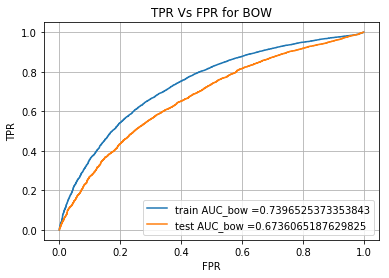

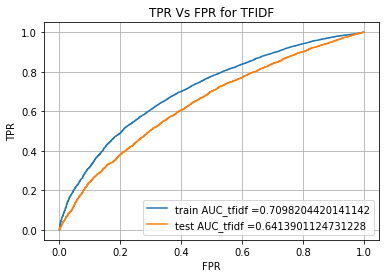

In [8]:
def batch_predict(clf, data):
    # roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
    # not the predicted outputs

    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000
    # consider you X_tr shape is 49041, then your tr_loop will be 49041 - 49041%1000 = 49000
    # in this for loop we will iterate unti the last 1000 multiplier
    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])
    # we will be predicting for the last data points
    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

from sklearn.metrics import roc_curve, auc
best_alpha_bow = 0.00001
multi_NB_bow = MultinomialNB(alpha=best_alpha_bow,class_prior=[0.5, 0.5])
best_alpha_tfidf = 0.00001
multi_NB_tfidf = MultinomialNB(alpha=best_alpha_tfidf,class_prior=[0.5, 0.5])
multi_NB_bow.fit(X_tr_bow, y_train)
multi_NB_tfidf.fit(X_tr_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred_bow = batch_predict(multi_NB_bow, X_tr_bow)    
y_test_pred_bow = batch_predict(multi_NB_bow, X_tst_bow)

y_train_pred_tfidf = batch_predict(multi_NB_tfidf, X_tr_tfidf)    
y_test_pred_tfidf = batch_predict(multi_NB_tfidf, X_tst_tfidf)

train_fpr_bow, train_tpr_bow, tr_thresholds_bow = roc_curve(y_train, y_train_pred_bow)
test_fpr_bow, test_tpr_bow, te_thresholds_bow = roc_curve(y_test, y_test_pred_bow)

train_fpr_tfidf, train_tpr_tfidf, tr_thresholds_tfidf = roc_curve(y_train, y_train_pred_tfidf)
test_fpr_tfidf, test_tpr_tfidf, te_thresholds_tfidf = roc_curve(y_test, y_test_pred_tfidf)

plt.plot(train_fpr_bow, train_tpr_bow, label="train AUC_bow ="+str(auc(train_fpr_bow, train_tpr_bow)))
plt.plot(test_fpr_bow, test_tpr_bow, label="test AUC_bow ="+str(auc(test_fpr_bow, test_tpr_bow)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("TPR Vs FPR for BOW")
plt.grid()
plt.show()

plt.plot(train_fpr_tfidf, train_tpr_tfidf, label="train AUC_tfidf ="+str(auc(train_fpr_tfidf, train_tpr_tfidf)))
plt.plot(test_fpr_tfidf, test_tpr_tfidf, label="test AUC_tfidf ="+str(auc(test_fpr_tfidf, test_tpr_tfidf)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("TPR Vs FPR for TFIDF")
plt.grid()
plt.show()

In [9]:
# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

from sklearn.metrics import confusion_matrix
best_t_bow = find_best_threshold(tr_thresholds_bow, train_fpr_bow, train_tpr_bow)
best_t_tfidf = find_best_threshold(train_fpr_tfidf, train_fpr_tfidf, train_tpr_tfidf)
print("Train confusion matrix for BOW")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_bow, best_t_bow)))
print("Test confusion matrix for BOW")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_bow, best_t_bow)))

print("Train confusion matrix for TFIDF")
print(confusion_matrix(y_train, predict_with_best_t(y_train_pred_tfidf, best_t_tfidf)))
print("Test confusion matrix for TFIDF")
print(confusion_matrix(y_test, predict_with_best_t(y_test_pred_tfidf, best_t_tfidf)))

the maximum value of tpr*(1-fpr) 0.4645265810843107 for threshold 0.576
the maximum value of tpr*(1-fpr) 0.428748397380424 for threshold 0.33
Train confusion matrix for BOW
[[ 3746  1619]
 [ 9417 18718]]
Test confusion matrix for BOW
[[1623 1019]
 [4996 8862]]
Train confusion matrix for TFIDF
[[ 1504  3861]
 [ 2722 25413]]
Test confusion matrix for TFIDF
[[  588  2054]
 [ 1529 12329]]


In [10]:
# The below code is taken reference from https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

feature_prob=(abs(multi_NB_bow.feature_log_prob_))
for i in range(len(feature_prob)):
    print ('top 20 features for {} class'.format(i))
    clas = feature_prob[i,:]
    dictonary={}
    for count,ele in enumerate(clas,0): 
      dictonary[count]=ele
    dictonary=dict(sorted(dictonary.items(), key=lambda x: x[1], reverse=True)[:20])
    keys=list(dictonary.keys())
    print(keys[:21])   

  

top 20 features for 0 class
[5159, 5182, 5192, 5247, 5135, 5157, 5174, 5183, 5184, 5185, 5219, 5249, 5074, 5099, 5104, 5106, 5140, 5144, 5148, 5158]
top 20 features for 1 class
[5167, 5128, 5140, 5145, 5147, 5158, 5187, 5239, 5119, 5173, 5183, 5185, 5195, 5058, 5096, 5134, 5153, 5159, 5175, 5192]


<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [11]:
from tabulate import tabulate
summary_lst = []
summary_lst.append(["BOW", "NB", best_alpha_bow, auc(train_fpr_bow, train_tpr_bow)])
summary_lst.append(["TF-IDF", "NB", best_alpha_tfidf, auc(train_fpr_tfidf, train_tpr_tfidf)])
print(tabulate(summary_lst, headers=['Vectorizer', 'Model', 'Hyper parameter', 'AUC']))

Vectorizer    Model      Hyper parameter       AUC
------------  -------  -----------------  --------
BOW           NB                   1e-05  0.739653
TF-IDF        NB                   1e-05  0.70982
